In [6]:
%cd ~/desktop/RNA/casp16
casp_id = "M1282"
pdb_dir=f"./datasets/casp16/{casp_id}/zdock/pdb"

/Users/sumishunsuke/Desktop/RNA/casp16


# energy 

In [7]:
!ls {pdb_dir}/*pdb | wc -l

!python ./scripts/eval_scores.py --pdb_dir {pdb_dir} --out_dir {pdb_dir} --cpu 8

    1000
['zdock.S_000485-top1.pdb', 'zdock.S_000815-top1.pdb', 'zdock.S_000484-top1.pdb', 'zdock.S_000814-top1.pdb']
Traceback (most recent call last):
  File "/Users/sumishunsuke/Desktop/RNA/casp16/./scripts/eval_scores.py", line 83, in <module>
    main()
  File "/Users/sumishunsuke/Desktop/RNA/casp16/./scripts/eval_scores.py", line 66, in main
    res_rnabriq = RNA_BRiQ.RNA_BRiQ_eval_batch(args.pdb_dir, args.out_dir, args.cpu)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sumishunsuke/Desktop/RNA/casp16/./src/score/RNA_BRiQ.py", line 67, in RNA_BRiQ_eval_batch
    energy = float(lines[-1].strip().replace("Energy: ", ""))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'check ribose:'


In [8]:
!say "evaluation done"

In [12]:
all_pdb_ids = !ls {pdb_dir}/*pdb | xargs -n 1 basename | cut -d. -f2 | cut -d- -f1
all_pdb_ids[:3]

['S_000001', 'S_000002', 'S_000003']

In [20]:
# re-proc

all_pdb_ids = !ls {pdb_dir}/*pdb | xargs -n 1 basename | cut -d. -f2 | cut -d- -f1
print(len(all_pdb_ids))

energies = {}
unprocessed = []
for pdb_id in all_pdb_ids:
    f = f"{pdb_dir}/zdock.{pdb_id}-top1.briq.out"
    try:
        with open(f) as fh: lines = fh.readlines()
        energies[f] = float(lines[-1].strip().replace("Energy: ", ""))
    except:
        unprocessed.append(pdb_id)

print(len(energies), len(unprocessed))

1000
1000 0


In [21]:
# import sys
# sys.path.append("./")
# from src.score import RNA_BRiQ
# from multiprocessing import Pool

# with Pool(3) as pool:
#     results = pool.map(
#         RNA_BRiQ.process_pdb_file_eval,
#         [f"{pdb_dir}/zdock.{pdb_id}-top1.pdb" for pdb_id in unprocessed]
#         )

# energy書き出し

In [24]:
out_files[:1]

['./datasets/casp16/M1282/zdock/pdb/zdock.S_000001-top1.briq.out']

In [31]:
out_files = !ls {pdb_dir}/*briq.out

pdb_energy = {}
for out in out_files:
    with open(out) as fh: 
        lines = fh.readlines()
    energies = float(lines[-1].strip().replace("Energy: ", ""))
    basename = out.split("/")[-1].replace("-top1.briq.out", "").replace("zdock.", "")
    pdb_energy[basename] = energies


# pdb_energy["S_000001"]

import pandas as pd
df_briq = pd.DataFrame(pdb_energy.items(), columns=["pdb", "BRiQscore"])
df_briq.head(3)

,pdb,BRiQscore
0,S_000001,-12.0093
1,S_000002,-38.6090
2,S_000003,-88.8257


In [43]:
df_zdock = pd.read_csv(f"{pdb_dir}/ZDOCKscore.csv", header=None)
df_zdock.columns = ["pdb", "ZDOCKscore"]
print(df_zdock.head(3))

                       pdb  ZDOCKscore
0  zdock.S_000001-top1.pdb    2621.857
1  zdock.S_000002-top1.pdb    2662.368
2  zdock.S_000003-top1.pdb    2473.150


In [46]:
import pandas as pd 
df_zdock = pd.read_csv(f"{pdb_dir}/ZDOCKscore.csv", header=None)
df_zdock.columns = ["pdb", "ZDOCKscore"]
df_zdock["pdb"] = [f.split("/")[-1].replace("zdock.", "").replace("-top1.pdb", "") for f in df_zdock["pdb"]]
df = pd.merge(df_briq, df_zdock, on="pdb")
df.shape

df.to_csv(f"{pdb_dir}/{casp_id}_scores.csv", index=False)

(436, 3)


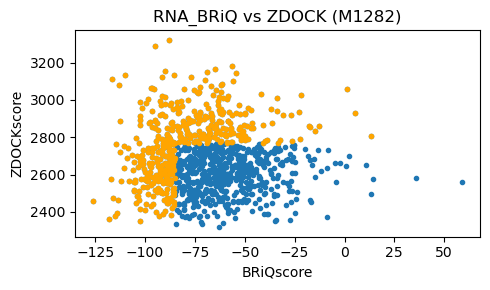

In [10]:
import pandas as pd
import os
import matplotlib.pyplot as plt

df_scores = pd.read_csv(f"{pdb_dir}/{casp_id}_scores.csv")


n_take = 250
df_briq_top = df_scores.sort_values("BRiQscore", ascending=True).head(n_take)
df_zdock_top = df_scores.sort_values("ZDOCKscore", ascending=True).tail(n_take)
df_both_top = pd.concat([df_briq_top, df_zdock_top]).drop_duplicates()


plt.figure(figsize=(5,3))
plt.scatter(df_scores["BRiQscore"], df_scores["ZDOCKscore"], marker=".")
plt.scatter(df_both_top["BRiQscore"], df_both_top["ZDOCKscore"], marker=".", color="orange", label=f"Top {n_take}")
# plt.legend()
plt.xlabel("BRiQscore")
plt.ylabel("ZDOCKscore")
plt.title(f"RNA_BRiQ vs ZDOCK ({casp_id})")

print(df_both_top.shape)
plt.tight_layout()
# plt.savefig(f"{pdb_dir}/{casp_id}_scores.pdf")

In [14]:
# for i,row in df_both_top.iterrows():
#     pdb = row["pdb"]
#     !cp {pdb_dir}/zdock.{pdb}-top1.pdb datasets/casp16/M1282/zdock/top_pdb

# 距離計算

In [15]:
%cd ~/desktop/RNA/casp16
import warnings
warnings.filterwarnings('ignore')
from Bio import PDB
import numpy as np
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser, Superimposer
import os
import pandas as pd

casp_id = "M1282"
pdb_dir=f"./datasets/casp16/{casp_id}/zdock/pdb"
top_pdb_dir=f"./datasets/casp16/{casp_id}/zdock/top_pdb"

/Users/sumishunsuke/Desktop/RNA/casp16


In [50]:
# !time python scripts/calc_rmsd.py --pdb_dir {top_pdb_dir} --cpu 8 --print_every 5
!time python scripts/calc_rmsd.py --pdb_dir {pdb_dir} --cpu 8 --print_every 5

['zdock.S_000001-top1.pdb', 'zdock.S_000002-top1.pdb', 'zdock.S_000003-top1.pdb', 'zdock.S_000004-top1.pdb', 'zdock.S_000005-top1.pdb']
Number of pdb files: 1000
Calculating RMSD matrix 1000x1000 using 8 cpus
Calculating RMSD for 0th pdb file
Calculating RMSD for 65th pdb file
^C
Process SpawnPoolWorker-4:
Process SpawnPoolWorker-3:
Process SpawnPoolWorker-7:
Process SpawnPoolWorker-5:
Process SpawnPoolWorker-6:
Process SpawnPoolWorker-8:
Traceback (most recent call last):
  File "/Users/sumishunsuke/micromamba/envs/casp16/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/sumishunsuke/micromamba/envs/casp16/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/sumishunsuke/micromamba/envs/casp16/lib/python3.12/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Users/sumishunsuke/micromamb

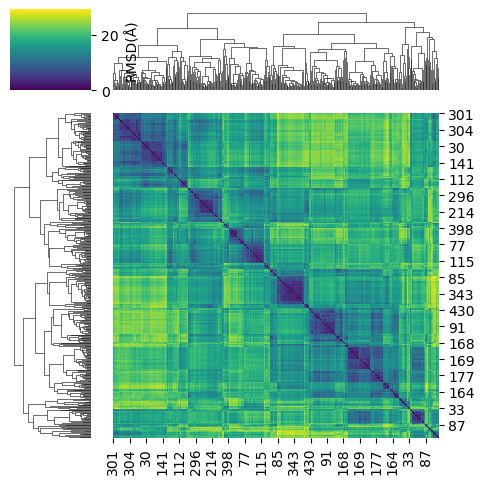

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

rmsd = np.load(f"{top_pdb_dir}/rmsd_matrix_sorted_id.npy")
g = sns.clustermap(rmsd, cmap="viridis", figsize=(5,5), cbar_kws={'label': 'RMSD(Å)', 'aspect': 20})
plt.tight_layout()
plt.savefig(f"{top_pdb_dir}/rmsd_clustermap.png", dpi = 300)

In [21]:
all_pdb_ids = !ls {top_pdb_dir}/*pdb | xargs -n 1 basename | cut -d. -f2 | cut -d- -f1
print(len(all_pdb_ids))
print(all_pdb_ids[:3])

436
['S_000003', 'S_000004', 'S_000006']


In [22]:
df_rmsd = pd.DataFrame(rmsd, columns=all_pdb_ids, index=all_pdb_ids)
df_rmsd.to_csv(f"{top_pdb_dir}/rmsd_matrix_sorted_id.csv")

# clustering

In [23]:
import numpy as np
from sklearn.manifold import MDS

rmsd = np.load(f"{top_pdb_dir}/rmsd_matrix_sorted_id.npy")
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42, n_jobs=7, max_iter=1000)
coords = mds.fit_transform(rmsd)

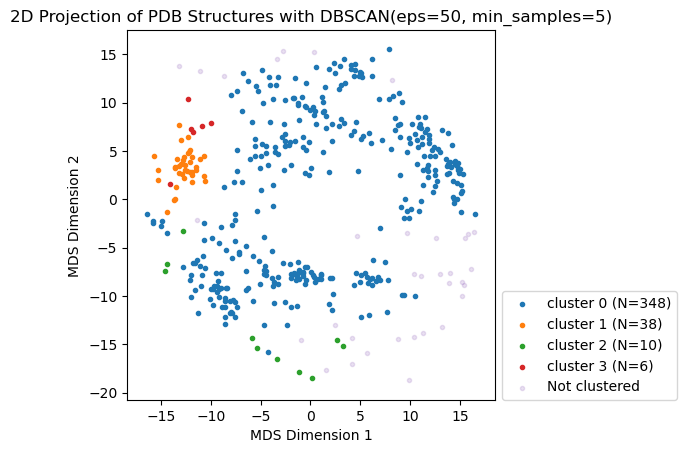

In [46]:
from sklearn.cluster import DBSCAN
eps =  50
min_samples = 5
clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(rmsd)

plt.figure()
for c in set(clustering.labels_):
    if c == -1: 
        plt.scatter(coords[clustering.labels_ == c, 0], coords[clustering.labels_ == c, 1], label="Not clustered", marker=".", alpha=0.2)
    else:
        n = sum(clustering.labels_ == c)
        plt.scatter(coords[clustering.labels_ == c, 0], coords[clustering.labels_ == c, 1], label=f"cluster {c} (N={n})", marker=".")
plt.legend(loc = (1.02,0))
plt.xlim(min(coords[:, 0])-2, max(coords[:, 0])+2)
plt.ylim(min(coords[:, 1])-2, max(coords[:, 1])+2)

# plt.colorbar(label=label)
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.title(f'2D Projection of PDB Structures with DBSCAN(eps={eps}, min_samples={min_samples})')
plt.subplots_adjust(right=0.7)
plt.savefig(f"{top_pdb_dir}/rmsd_mds_dbscan_eps{eps}_min_samples{min_samples}.png", dpi=300)
plt.show()


In [47]:
import pandas as pd

df_scores = pd.read_csv(f"{pdb_dir}/{casp_id}_scores.csv")
top_pdbs = !ls {top_pdb_dir}/*.pdb
top_pdbs = [os.path.basename(pdb).replace("-top1.pdb", "").replace("zdock.", "") for pdb in top_pdbs]
df_scores = df_scores[df_scores["pdb"].isin(top_pdbs)]
df_scores.head(2)

,pdb,BRiQscore,ZDOCKscore
2,S_000003,-88.8257,2473.150
3,S_000004,-59.9587,2815.812


In [48]:
df_scores["cluster"] = clustering.labels_
df_scores.to_csv(f"{top_pdb_dir}/{casp_id}_scores_clustered_eps{eps}.csv", index=False)
df_scores = pd.read_csv(f"{top_pdb_dir}/{casp_id}_scores_clustered_eps{eps}.csv")
df_scores.head(3)

,pdb,BRiQscore,ZDOCKscore,cluster
0,S_000003,-88.8257,2473.150,-1
1,S_000004,-59.9587,2815.812,0
2,S_000006,-87.1703,2600.534,0


In [49]:
pdb_list = []

print(" Sorted by BRiQscore")
print(df_scores.sort_values("BRiQscore").head(5))
pdb_list.extend(df_scores.sort_values("BRiQscore").head(5)["pdb"].values)
print(" Sorted by ZDOCKscore")
print(df_scores.sort_values("ZDOCKscore").tail(5))
pdb_list.extend(df_scores.sort_values("ZDOCKscore").tail(5)["pdb"].values)
print("**"*20)



 Sorted by BRiQscore
          pdb  BRiQscore  ZDOCKscore  cluster
288  S_000689   -126.025    2460.416        0
92   S_000221   -118.334    2363.492        0
48   S_000107   -116.915    2576.197        0
400  S_000923   -116.719    3112.461        0
269  S_000632   -115.999    2473.252        0
 Sorted by ZDOCKscore
          pdb  BRiQscore  ZDOCKscore  cluster
218  S_000520   -90.0354    3154.996        3
171  S_000401   -64.9920    3163.237        0
314  S_000745   -56.4767    3183.208        0
211  S_000506   -94.8017    3290.603        1
350  S_000807   -87.8732    3322.242        0
****************************************
